# Modeling and Inferential Analysis

In this section we're going to look at the predictive power of certain variables by fitting a logistic regression base model as well as RandomForests to understand which features are most important.

This is different from our statistical tests above that are looking at a Hypothesis and decide whether or not the result is very unlikely to have happened by chance but rather this analysis helps us decide whether or not it could be beneficial to increase model complexity by using a feature due to its predictive power [https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf](https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf). 

This is always a trade-off as increasing our model complexity could lead to better results on our data but also makes a model prone to overfitting (e.g. a famous example of this is neural networks classifing dogs and wolves. Instead of learning the difference between dogs and wolves using their characteristics they used the surrounding environment, i.e. snow = wolf and dog = grass) [https://arxiv.org/abs/1602.04938](https://arxiv.org/abs/1602.04938).

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

mlp.rcParams['figure.figsize'] = (10,6)

sns.set()
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

train = pd.read_csv('../data/processed/train.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])

In [3]:
features = ['acousticness','loudness','instrumentalness','danceability','valence','energy','tempo','duration_ms','time_signature','key','mode']
predictor = ['hit']

In [4]:
features_with_target = ['hit','danceability', 'energy', 'key','mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','time_signature']

In [5]:
from sklearn.model_selection import train_test_split

Xy_train = train.loc[:,features + predictor].dropna()
X = Xy_train.drop('hit',axis=1)
y = Xy_train['hit']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.33, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train,X_test):
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

X_train, X_test, scaler = scale_data(X_train, X_test)

LR Scores:  [0.67249887 0.65597434 0.66411479 0.69004744 0.66779966]
Mean ROC AUC Score: 0.6700870198849793
LR Score Range: 0.0341


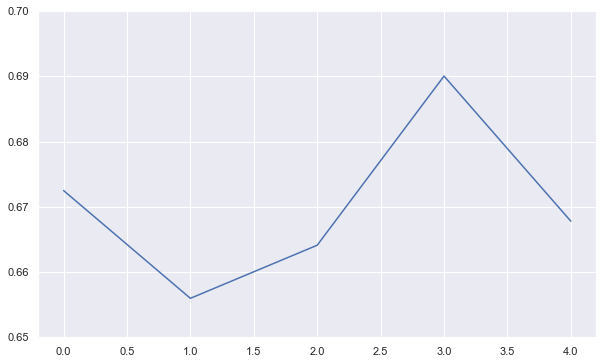

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def run_lr(X_train,y_train):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    lr = LogisticRegression(solver='lbfgs')
    
    lr_scores = cross_val_score(lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='roc_auc')
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)
    _ = plt.ylim(0.65,0.7)
    return lr

lr = run_lr(X_train,y_train)

Using the Baseline model and all features available to us we can see quite some variability in the ROC AUC Score. This usually indicates overfitting. Let's see if we can reduce that overfitting by reducing the dimensionality of the problem.

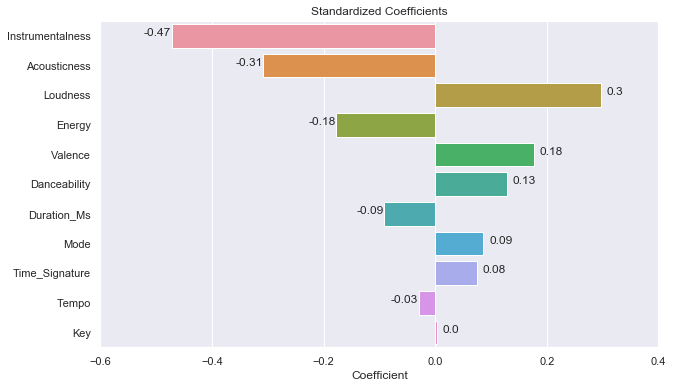

In [8]:
def plot_coef(X,y,features):
    lr = LogisticRegression(solver='lbfgs')
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    lr.fit(X_train,y_train)
    std_coef = lr.coef_.reshape(-1,1).tolist()
    feature_names = [feature.title() for feature in features]
    coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
    coef_df['abs'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
    ax = sns.barplot(coef_df['coef'],coef_df.index)
    for i, row in enumerate(coef_df.iterrows()):
        row_values = row[1]
        if row_values.coef < 0:
            ax.text(row_values.coef - 0.05,i,round(row_values.coef,2))
        else:
            ax.text(row_values.coef + 0.01,i,round(row_values.coef,2))
    _ = plt.xlabel('Coefficient')
    _ = plt.title('Standardized Coefficients')
    _ = plt.xlim(-0.6,0.4)

plot_coef(X_train,y_train,features)

Using Logistic Regression Beta based on standardized values allows us to evaluate the relative importance of the features used. We can see at the top are three features to detect hits:
- Instrumentalness
- Acousticness
- Loudness

At the bottom we can see two features:
- Tempo
- Key

Interestingly, a continuous feature such as tempo seems to have very little influence on whether the model can become a hit or not. It might be interesting, if Tempo would perform better if the model was taking time/year into account. The Key feature expectedly scores low in weight, no surprise there.

We can also see that 
- Mode 
- Time Signature 

are performing better than expected. However, as we've evaluated in the EDA mode and time_signature features aren't convincing features, these could quickly change and might overfit our model rather than leading to actual higher accuracy.

Hence, we'll drop Tempo, Mode, Key and Time Signature.

In [9]:
# Remove more features
X_tune_skim = X_tune.drop(['tempo','mode','key','time_signature'],axis=1)
X_tune_skim.head()

,,acousticness,loudness,instrumentalness,danceability,valence,energy,duration_ms
artist,title,,,,,,,
Nicky Jam + Ozuna,Te Robaré,0.241,-3.572,0.000045,0.673,0.7970,0.752,201818.0
K.T. Oslin,"Dr., Dr.",0.414,-11.299,0.000451,0.699,0.6570,0.449,207520.0
Jorge Celedón + Binomio de Oro de América,Olvídala,0.139,-5.136,0.000000,0.533,0.6150,0.727,306307.0
Acoustic Alchemy,Caravan Of Dreams,0.973,-14.986,0.807000,0.609,0.5140,0.175,181000.0
Nataural,Florida Rain Storm,0.002,-20.970,0.759000,0.211,0.0358,0.774,170922.0


### Check for Collinearity

Collinearity of features can cause models to be unstable and overemphasizes certain features among other issues.

In [10]:
tune = pd.concat([X_tune_skim,y_tune.astype(int)],axis=1)
tune.head()

,,acousticness,loudness,instrumentalness,danceability,valence,energy,duration_ms,hit
artist,title,,,,,,,,
Nicky Jam + Ozuna,Te Robaré,0.241,-3.572,0.000045,0.673,0.7970,0.752,201818.0,0
K.T. Oslin,"Dr., Dr.",0.414,-11.299,0.000451,0.699,0.6570,0.449,207520.0,0
Jorge Celedón + Binomio de Oro de América,Olvídala,0.139,-5.136,0.000000,0.533,0.6150,0.727,306307.0,0
Acoustic Alchemy,Caravan Of Dreams,0.973,-14.986,0.807000,0.609,0.5140,0.175,181000.0,0
Nataural,Florida Rain Storm,0.002,-20.970,0.759000,0.211,0.0358,0.774,170922.0,0


In [11]:
# find correlations to target
corr_matrix = X_tune_skim.corr().abs()

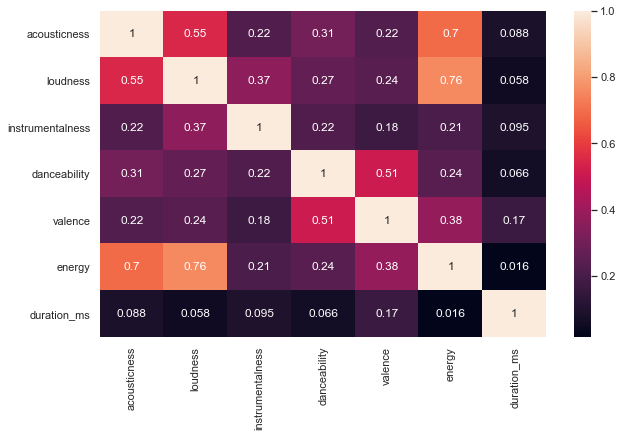

In [12]:
sns.heatmap(corr_matrix,annot=True)
plt.show;

In [13]:
corr_matrix.energy[:2]

acousticness    0.696114
loudness        0.758092
Name: energy, dtype: float64

We can see that Energy has a medium to strong correlation with acousticness and loudness. Due to the size of our samples most of the correlations will be significant. For due diligence we'll double-check that this is true.
    
- **H0**: The population correlation coefficient _is not_ significantly different from zero. There _is not_ a significant correlation between 'energy' and 'loudness' in the population.
- **H1**: The population correlation coefficient _is_ significantly different from zero. There _is_ a significant correlation between 'energy' and 'loudness' in the population.
- **alpha**: 0.05

In [14]:
from scipy.stats import pearsonr

alpha = 0.05

energy_loudness_corr = pearsonr(tune.energy,tune.loudness)
energy_acousticness_corr = pearsonr(tune.energy,tune.acousticness)

print("The Correlation of Energy and Loudness is {}. With a p-value of {} there is a significant relationship for alpha {}.".format(energy_loudness_corr[0],energy_loudness_corr[1],alpha))
print("The Correlation of Energy and Acousticness is {}. With a p-value of {} there is a significant negative relationship for alpha {}.".format(energy_acousticness_corr[0],energy_acousticness_corr[1],alpha))

The Correlation of Energy and Loudness is 0.7580922945666533. With a p-value of 0.0 there is a significant relationship for alpha 0.05.
The Correlation of Energy and Acousticness is -0.6961137007209003. With a p-value of 0.0 there is a significant negative relationship for alpha 0.05.


However, there might still be information in Energy as a feature, which is why we'll leave it in and hope that the issue can be resolved using dimensionality reduction (PCA) in the next step.

There is also a medium correlation between loudness and acousticness.

In [15]:
# Remove energy from features
corr_matrix.loudness[:1]

acousticness    0.549694
Name: loudness, dtype: float64

In [16]:
from scipy.stats import pearsonr

alpha = 0.05

loudness_acousticness_corr = pearsonr(tune.acousticness,tune.loudness)
valence_danceability_corr = pearsonr(tune.valence,tune.danceability)

print("The Correlation of Loudness and Acousticness is {}. With a p-value of {} there is a significant negative relationship for alpha {}.".format(loudness_acousticness_corr[0],loudness_acousticness_corr[1],alpha))
print("The Correlation of Valence and Danceability is {}. With a p-value of {} there is a significant positive relationship for alpha {}.".format(valence_danceability_corr[0],valence_danceability_corr[1],alpha))

The Correlation of Loudness and Acousticness is -0.5496941951584116. With a p-value of 0.0 there is a significant negative relationship for alpha 0.05.
The Correlation of Valence and Danceability is 0.5116711695729688. With a p-value of 0.0 there is a significant positive relationship for alpha 0.05.


Similarly to the correlation between Energy, Loudness and Acousticness, these features still might hold valuable information and we'll remove any collinearity via dimensionality reduction (PCA) in the next step, so as not to lose as much information as we would if we removed a feature.

In [17]:
# Remove more features
tune_clean = tune.drop([],axis=1)

LR Scores:  [0.67067822 0.65441601 0.66077361 0.68978917 0.66497553]
Mean ROC AUC Score: 0.6681265079392905
LR Score Range: 0.0354


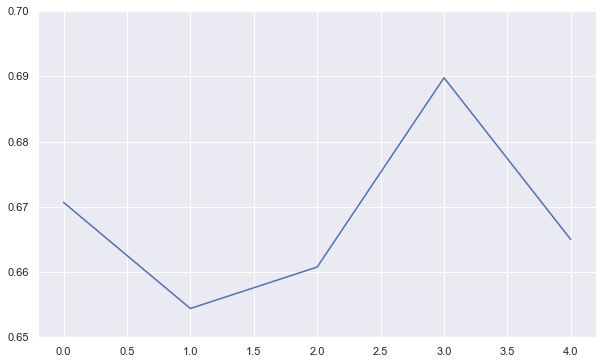

In [18]:
X_tune_cl = tune_clean.drop('hit', axis=1)
y_tune_cl = tune_clean['hit']
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_tune_cl, y_tune_cl, test_size=0.33, random_state=42)

X_train_sc, X_test_sc, scaler_sc = scale_data(X_train_cl,X_test_cl)

lr = run_lr(X_train_sc,y_train_cl)

Removing the 3 features from the model has not significantly affected the Cross Validation output. There was a slight increase of 0.17 in the LR Score Range but we have been able to remove some features with very low correlation metrics.

### Dimensionality Reduction

After we've selected our relevant features we can now use PCA to reduce our features to their intrinsic dimensions.

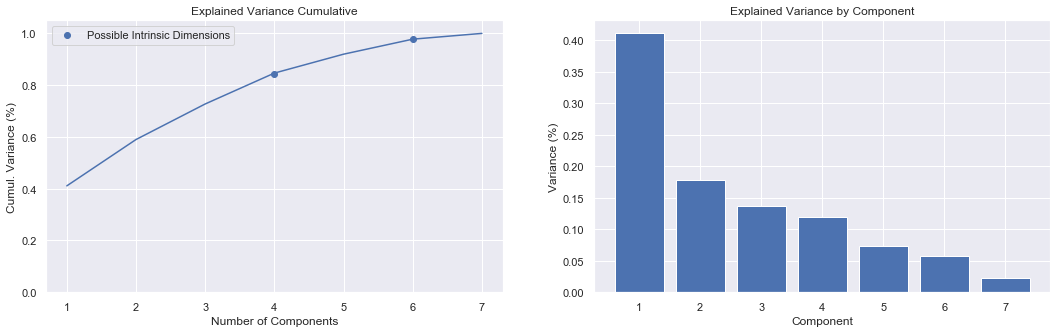

In [19]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA()
pca.fit(X_train_sc)

#Plotting the Cumulative Summation of the Explained Variance
fig, ax = plt.subplots(1,2,figsize=(18,5))

plt.subplot(1,2,1)
explained_var_ratio = pca.explained_variance_ratio_
explained_cum_var = np.cumsum(explained_var_ratio)
_ = plt.plot(explained_cum_var)
_ = plt.xticks(np.arange(0,len(explained_cum_var)),np.arange(1,len(explained_cum_var) + 1) )
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Cumul. Variance (%)') #for each component
_ = plt.ylim(0,1+0.05)
_ = plt.title('Explained Variance Cumulative')
_ = plt.scatter([5,3],[0.98,0.845],label='Possible Intrinsic Dimensions')
_ = plt.legend(loc='upper left')

plt.subplot(1,2,2)
_ = plt.bar(np.arange(1, len(explained_var_ratio) + 1),explained_var_ratio)
_ = plt.xlabel('Component')
_ = plt.ylabel('Variance (%)') #for each component
_ = plt.title('Explained Variance by Component')

It's clear that our data has either 4 or 6 intrinsic dimensions as the explained variance drops at those points. To avoid overfitting we'll use 4 components.

In [20]:
pca4 = PCA(n_components=4)
X_train_reduced = pca4.fit_transform(X_train_sc)
X_test_reduced = pca4.transform(X_test_sc)

LR Scores:  [0.6606021  0.65200614 0.65630728 0.68475208 0.66135511]
Mean ROC AUC Score: 0.6630045410348305
LR Score Range: 0.0327


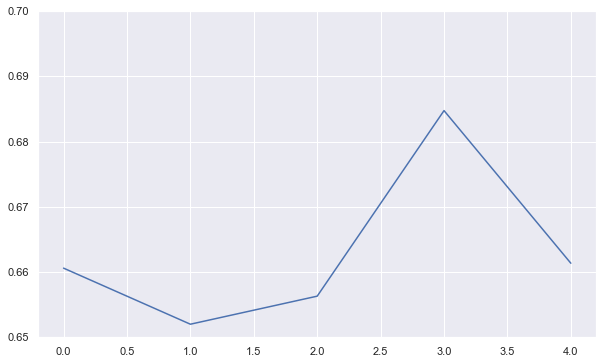

In [21]:
lr = run_lr(X_train_reduced,y_train_cl)

Unfortunately, our gains in reducing the LR Score range are minimal. As expected we've also lost a little bit of overall ROC AUC score but that is almost negligible. Hopefully the model has gained some stability through this process. We'll now go on to optimizing parameters.

### Optimizing Hyperparameters

In this step we're using cross validation to optimize parameters over our tuning data.

/Users/sebastian/anaconda3/envs/hit_predictor/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


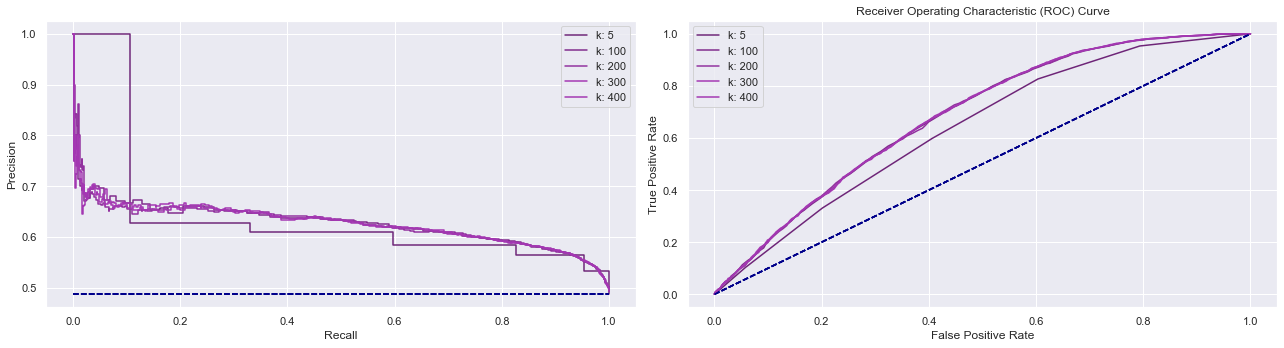

Max Precision-Recall AUC: 0.6266281766895034 at 300 estimators
Max ROC AUC: 0.6861107204337631 at 300 estimators


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

# The function
def plot_pr_curve(y_test,y_pred,hyperparameter,color,ax=False):
    precision,recall,threshold = precision_recall_curve(y_test,y_pred)
    
    if ax:
        _ = ax.step(recall,precision,label='k: {}'.format(hyperparameter),color=color)
        dumb = len(y_test[y_test>0])/len(y_test)
        _ = ax.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
        _ = ax.set_xlabel('Recall')
        _ = ax.set_ylabel('Precision')
        
        ax.legend()
    else:
        _ = plt.step(recall,precision,label='k: {}'.format(hyperparameter),color=color)
        dumb = len(y_test[y_test>0])/len(y_test)
        _ = plt.plot([0,1],[dumb,dumb], color='darkblue', linestyle='--')
        _ = plt.xlabel('Recall')
        _ = plt.ylabel('Precision')
        
        plt.legend()
    
    pr_auc = auc(recall,precision)
    return pr_auc

# The ROC function
def plot_roc_curve(y_test, y_pred, hyperparameter,color,ax=False):  
    """
        Plot Roc Curve using predictions or probabilities
    """
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    
    if ax:
        _ = ax.plot(fpr, tpr, label='k: {}'.format(hyperparameter),color=color)
        _ = ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        _ = ax.set_xlabel('False Positive Rate')
        _ = ax.set_ylabel('True Positive Rate')
        _ = ax.set_title('Receiver Operating Characteristic (ROC) Curve') 
        
        ax.legend()
    else:
        _ = plt.plot(fpr, tpr, label='k: {}'.format(hyperparameter),color=color)
        _ = plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        _ = plt.xlabel('False Positive Rate')
        _ = plt.ylabel('True Positive Rate')
        _ = plt.title('Receiver Operating Characteristic (ROC) Curve')
        
        plt.legend()
    
    roc_auc = roc_auc_score(y_test_cl,y_pred)
    return roc_auc

estimators = np.arange(0,500,100)
estimators[0] = 5
pr_aucs = np.empty(len(estimators))
roc_aucs = np.empty(len(estimators))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

colorsP = colorsP + colorsP

for i,k in enumerate(estimators):
    rf = RandomForestClassifier(n_estimators=k,random_state=42)
    rf.fit(X_train_reduced,y_train_cl)

    y_test_pred = rf.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = estimators[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = estimators[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} estimators".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} estimators".format(best_roc_auc,best_roc_auc_k))

In [23]:
# Create RandomForest Classifier with Best Precision Recall Hyperparameter
rf_best = RandomForestClassifier(n_estimators=best_pr_k,random_state=42)
_ = rf_best.fit(X_train_reduced,y_train_cl)

In [24]:
from sklearn.pipeline import make_pipeline

# Create A Pipeline for the Best RandomForest Classifier
pipeline_rf = make_pipeline(StandardScaler(), PCA(n_components=4), RandomForestClassifier(n_estimators=best_pr_k, random_state=42))
rf_best = pipeline_rf.fit(X_train_cl,y_train_cl)

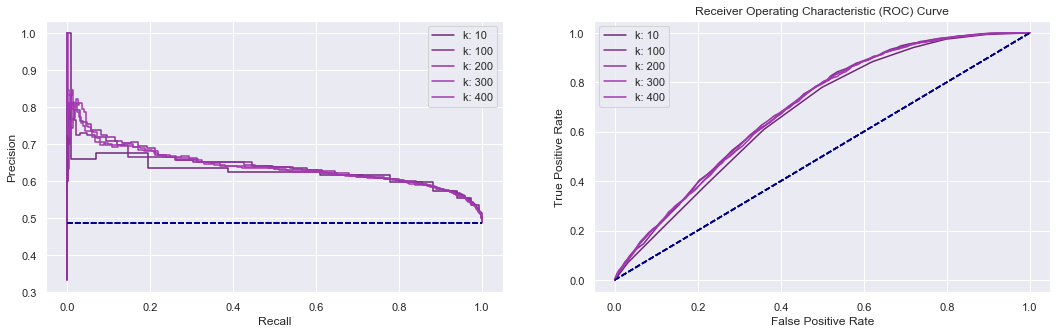

<Figure size 1296x576 with 0 Axes>

Max Precision-Recall AUC: 0.6413749303185391 at 200 neighbors
Max ROC AUC: 0.697037516155492 at 200 neighbors


In [25]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(0,500,100)
neighbors[0] = 10
pr_aucs = np.empty(len(neighbors))
roc_aucs = np.empty(len(neighbors))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))

fig = plt.figure(figsize=(18,8))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced,y_train_cl)

    y_test_pred = knn.predict_proba(X_test_reduced).T[1]
    pr_auc = plot_pr_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax1)
    roc_auc = plot_roc_curve(y_test_cl,y_test_pred,k,colorsP[i],ax=ax2)
    pr_aucs[i] = pr_auc
    roc_aucs[i] = roc_auc
    
_ = plt.tight_layout()

plt.show()

best_pr = pr_aucs.max()
best_pr_k = neighbors[np.where(pr_aucs == best_pr)[0]][0]
best_roc_auc = roc_aucs.max()
best_roc_auc_k = neighbors[np.where(roc_aucs == best_roc_auc)[0]][0]

print("Max Precision-Recall AUC: {} at {} neighbors".format(best_pr,best_pr_k))
print("Max ROC AUC: {} at {} neighbors".format(best_roc_auc,best_roc_auc_k))

In [26]:
# Create kNN Classifier with Best Precision Recall Hyperparameter
knn_best = KNeighborsClassifier(n_neighbors=best_pr_k)
knn_best.fit(X_train_cl,y_train_cl)

# Create Pipeline with kNN Classifier
pipeline_knn = make_pipeline(StandardScaler(), PCA(n_components=4), KNeighborsClassifier(n_neighbors=best_pr_k))
knn_best = pipeline_knn.fit(X_train_cl,y_train_cl)

In [27]:
from sklearn.metrics import log_loss,accuracy_score, precision_recall_fscore_support

def get_eval(clf,X,y_true):
    y_pred = clf.predict(X)
    accuracy = (np.nan,accuracy_score(y_true,y_pred))

    y_pred_proba = clf.predict_proba(X)
    logloss = (np.nan,log_loss(y_true,y_pred_proba))
    
    # Beta shifts the weight toward recall by a factor of beta (e.g. beta=0.5 -> recall is half as important as precision)
    beta = 1
    precision, recall, f1, support = precision_recall_fscore_support(y_true,y_pred,beta=beta)

    scores = ['accuracy','logloss','precision','recall','f1 beta={}'.format(beta),'support']
    labels = list(clf.classes_)
    display(pd.DataFrame([accuracy,logloss,precision,recall,f1,support],columns=labels,index=scores))

get_eval(pipeline_rf,X_test_cl,y_test_cl)

,0,1
accuracy,NaN,0.635704
logloss,NaN,0.634130
precision,0.663376,0.612533
recall,0.589084,0.684854
f1 beta=1,0.624026,0.646678
support,3536.000000,3354.000000


In [28]:
get_eval(pipeline_knn,X_test_cl,y_test_cl)

,0,1
accuracy,NaN,0.644848
logloss,NaN,0.617462
precision,0.745160,0.597130
recall,0.468043,0.831246
f1 beta=1,0.574952,0.695002
support,3536.000000,3354.000000


We can see that the KNeighbors classifier has slightly lower precision meaning more songs that are tagged as a Hit turn out not to be hits but the difference in precision is negligible compared to the performance of KNeighbors in terms of recall. KNeighbors is able to retrieve ~82% of all Hits.

# Validation

In the first step of this notebook we've created a Hold out set to validate that our model also works on unseen data (i.e. can be generalized). We're now looking at how KNeighbors performs on this Hold out set.

In [29]:
X_hold_skim = X_hold.drop(['tempo','mode','key','time_signature'],axis=1)
hold = pd.concat([X_hold_skim,y_hold.astype(int)],axis=1)
hold_clean = hold.drop([],axis=1)
X_hold_cl = hold_clean.drop('hit', axis=1)
y_hold_cl = hold_clean['hit'].astype(bool)

In [30]:
get_eval(pipeline_rf, X_hold_cl, y_hold_cl)

,0,1
accuracy,NaN,0.637592
logloss,NaN,0.629887
precision,0.654588,0.623488
recall,0.590636,0.685044
f1 beta=1,0.620970,0.652818
support,5169.000000,5115.000000


In [31]:
get_eval(pipeline_knn, X_hold_cl, y_hold_cl)

,0,1
accuracy,NaN,0.658790
logloss,NaN,0.613059
precision,0.752741,0.614714
recall,0.478236,0.841251
f1 beta=1,0.584881,0.710359
support,5169.000000,5115.000000


# Save the Model

In the following we're going to save the two models we've created.

In [32]:
from joblib import dump, load

# Save Models
_ = dump(knn_best, '../models/knn_model.joblib',compress=3)
_ = dump(rf_best, '../models/rf_model.joblib',compress=3)

# Save Pipelines
_ = dump(pipeline_knn, '../models/knn_pipeline.joblib',compress=3)
_ = dump(pipeline_rf, '../models/rf_pipeline.joblib',compress=3)

# Deploying the Model

Deploy the Model yourself or go the repository introduction and click on the link if you only want to try out some predictions.

In [33]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import os
from dotenv import load_dotenv

dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [34]:
# Please set your IBM credentials in an .env file (you'll have to create this file) in the root directory (../)
wml_credentials={
    'url': os.getenv("IBM_URL"),
    'username': os.getenv("IBM_USERNAME"),
    'password': os.getenv("IBM_PASSWORD"),
    'instance_id': os.getenv("IBM_INSTANCE_ID")
}

In [35]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### Save the pipeline and model

In [36]:
model_uid = '6b2ec26a-c91a-4740-b2c9-16a8a6dc431b'

In [37]:
# published_model_details = client.repository.store_model(model=knn_best, meta_props={'name':'KNN Hot 100 Predictor'}, training_data=X_train_cl, training_target=y_train_cl, pipeline=pipeline_knn)
# model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

6b2ec26a-c91a-4740-b2c9-16a8a6dc431b


Get saved model metadata from Watson Machine Learning.

**Tip**: Use `client.repository.ModelMetaNames.show()` to get the list of available props.

In [38]:
client.repository.ModelMetaNames.show()

-----------------------  ----  --------
META_PROP NAME           TYPE  REQUIRED
NAME                     str   Y
DESCRIPTION              str   N
AUTHOR_NAME              str   N
FRAMEWORK_NAME           str   N
FRAMEWORK_VERSION        str   N
FRAMEWORK_LIBRARIES      list  N
RUNTIME_NAME             str   N
RUNTIME_VERSION          str   N
TRAINING_DATA_SCHEMA     dict  N
INPUT_DATA_SCHEMA        dict  N
TRAINING_DATA_REFERENCE  dict  N
EVALUATION_METHOD        str   N
EVALUATION_METRICS       list  N
OUTPUT_DATA_SCHEMA       dict  N
LABEL_FIELD              str   N
TRANSFORMED_LABEL_FIELD  str   N
RUNTIME_UID              str   N
TRAINING_DEFINITION_URL  str   N
-----------------------  ----  --------


<a id="scoring"></a>
## 6. Deploy and score in the WML repository

#### Create an online deployment for the published model.

In [39]:
# If Deployment exists
deployment_uid = '5a9d3cb5-aae1-49bc-be7f-26539c9e7ec5'
deployment_details = client.deployments.get_details(deployment_uid)

In [40]:
# Create New Deployment
# deployment_details = client.deployments.create(model_uid, name='KNN Model for Hot 100 Prediction Model deployment')

#### Create an online scoring endpoint. 

In [41]:
scoring_url = 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/cc2d5c29-9b6a-4e09-a82c-8279e879d544/deployments/5a9d3cb5-aae1-49bc-be7f-26539c9e7ec5/online'

In [42]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/cc2d5c29-9b6a-4e09-a82c-8279e879d544/deployments/5a9d3cb5-aae1-49bc-be7f-26539c9e7ec5/online


You can now get new predictions for any song.

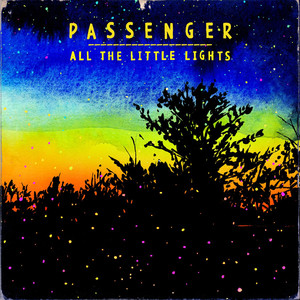

Let Her Go
Passenger
HIT
Certainty: 67.5


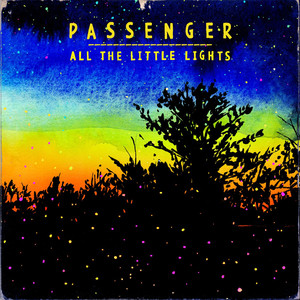

Let Her Go - Acoustic
Passenger
NO HIT
Certainty: 72.0


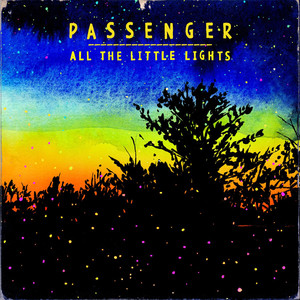

Let Her Go
Passenger
HIT
Certainty: 67.5


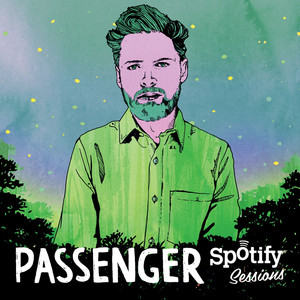

Let Her Go - Live At Spotify Amsterdam
Passenger
NO HIT
Certainty: 62.0


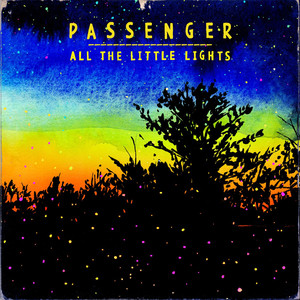

Let Her Go
Passenger
HIT
Certainty: 67.5


In [43]:
import spotipy
import requests as rq
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import Image,HTML

client_credentials_manager = SpotifyClientCredentials(client_id='e3cddf5da81f43c3a33814866a8de8ed', client_secret='f885f6255fb34c90b8679817d9c63c25')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

response = sp.search(q='passenger let her go')

top_5_songs = response['tracks']['items'][:5]

songs = []
for song in top_5_songs:
    img_url = song['album']['images'][1]['url']
    name = song['name']
    artists = []
    for artist in song['artists']:
        artists.append(artist['name'])
    artists = ' & '.join(artists)
    song_id = song['id']
    song_s = pd.DataFrame({'image': [img_url],
                 'name': [name],
                 'artists': [artists],
                 'id': [song_id]})
    songs.append(song_s)

# Concatenate Songs
songs_df = pd.concat(songs,ignore_index=True)

# Get Audio Features
response = sp.audio_features(songs_df['id'])
songs_to_pred = pd.DataFrame(response)

# Split Meta data from Features
song_ids = songs_to_pred.loc[:,['id','uri','track_href']]
song_features = songs_to_pred[features]

# Clean Songs for Prediction
song_features_cl = song_features.drop(['tempo','mode','key','time_signature'],axis=1)

# Load data for Prediction
payload_scoring = {'fields': song_features_cl.columns.tolist(),
                   'values': song_features_cl.values.tolist()}

res = client.deployments.score(scoring_url, payload_scoring)
predictions = pd.DataFrame(res['values'],columns=res['fields'])
predictions_df = pd.concat([song_ids,predictions],axis=1) 
predicted_songs = songs_df.merge(predictions_df,on='id')

for song in predicted_songs.iterrows():
    song_val = song[1]
    display(Image(rq.get(song_val['image']).content,width=100,height=100))
    print(song_val['name'])
    print(song_val['artists'])
    if song_val['prediction']:
        print('HIT')
        print('Certainty: {}'.format(round(song_val['probability'][1]*100,2)))
    else:
        print('NO HIT')
        print('Certainty: {}'.format(round(song_val['probability'][0]*100,2)))
    display(HTML('<a href="https://open.spotify.com/track/{}" target="_blank">Open in Browser</a> / <a href="{}" target="_blank">Open in App</a>'.format(song_val['id'],song_val['uri'])))
    print()

# Check if Song made it on the Hot 100

In [44]:
pd.options.display.max_columns = 400
pd.options.display.max_rows = 1000

In [45]:
hot100 = pd.read_csv('../data/processed/hot100.csv',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date'],sep='\t')
hot100_uniq = hot100.drop_duplicates(subset=['artist','title']).drop('rank',axis=1)

In [46]:
import ipywidgets as widgets
search_title = widgets.Text(
    value='Windy',
    description='Title:',
)

search_artist = widgets.Text(
    value='Shawn Mendes',
    description='Artist:',
)

uniq = widgets.Checkbox(
    value=False,
    description='Unique Songs'
)

submit = widgets.Button(description="Show Hot 100")

# Create Output Variable and Context Manager (necessary to clear old outputs)
out = widgets.Output(layout={'border': '1px solid black'})
def handle_title_submit(sender):
    out.clear_output()
    with out:
        if uniq.value:
            display(hot100_uniq.loc[hot100_uniq['title'].str.lower().str.contains(search_title.value.lower()),:])
        else: 
            display(hot100.loc[hot100['title'].str.lower().str.contains(search_title.value.lower()),:])

def handle_artist_submit(sender):
    out.clear_output()
    with out:
        if uniq.value:
            display(hot100_uniq.loc[hot100_uniq['artist'].str.lower().str.contains(search_artist.value.lower()),:])
        else: 
            display(hot100.loc[hot100['artist'].str.lower().str.contains(search_artist.value.lower()),:])

print('Check the Hot 100 for a Title or Artist\nNOTE: It\'s only possible to search for a title OR an artist at the moment')
search_title.on_submit(handle_title_submit)
search_artist.on_submit(handle_artist_submit)

display(search_title)
display(search_artist)
display(uniq)
display(out)

Check the Hot 100 for a Title or Artist
NOTE: It's only possible to search for a title OR an artist at the moment


Text(value='Windy', description='Title:')

Text(value='Shawn Mendes', description='Artist:')

Checkbox(value=False, description='Unique Songs')

Output(layout=Layout(border='1px solid black'))